In [1]:
import json
import networkx as nx
from networkx import json_graph
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
x_data = pd.read_json('noduplicatedataset.json',lines=True)

In [4]:
x_data['data_movements'] = 0
x_data['arithmetic'] = 0
x_data['shifts'] = 0
x_data['comparisons'] = 0
x_data['jumps'] = 0
x_data['calls'] = 0
x_data['bitwise'] = 0
x_data['func_reg'] = 0
x_data['stack_reg'] = 0
x_data['xmm_reg'] = 0

In [5]:
data_movements = ['mov ', 'cmov', 'push ', 'pop ', 'cwtl ', 'cltq ', 'cqto ', 'lea ']
arithmetic = ['inc ', 'dec ', 'neg ', 'not ', 'leaq ', 'add ', 'sub ', 'imul ', 'imulq ', 'mulq ', 'idivq ',
              'divq ', 'mul ']
bitwise = ['xor ', 'or ', 'and ']
shifts = ['sal ', 'shl ', 'sar ', 'shr ']
comparisons = ['cmp ', 'test ']
jumps = ['j']
calls = ['call ', 'leave ', 'ret ']
func_reg = [ 'rdi ', 'rsi ', 'rdx ', 'rcx ', 'r8 ', 'r9 ']
stack_reg = ['rsp ', 'rbp ']
spec_reg = ['xmm']

In [ ]:
for row in x_data.index:
  x_data['data_movements'][row] = sum(x_data['lista_asm'][row].count(str) for str in data_movements)
  x_data['arithmetic'][row] = sum(x_data['lista_asm'][row].count(str) for str in arithmetic)
  x_data['shifts'][row] = sum(x_data['lista_asm'][row].count(str) for str in shifts)
  x_data['comparisons'][row] = sum(x_data['lista_asm'][row].count(str) for str in comparisons)
  x_data['jumps'][row] = sum(x_data['lista_asm'][row].count(str) for str in jumps)
  x_data['calls'][row] = sum(x_data['lista_asm'][row].count(str) for str in calls)
  x_data['bitwise'][row] = sum(x_data['lista_asm'][row].count(str) for str in bitwise)
  x_data['func_reg'][row] = sum(x_data['lista_asm'][row].count(str) for str in func_reg)
  x_data['stack_reg'][row] = sum(x_data['lista_asm'][row].count(str) for str in stack_reg)
  x_data['xmm_reg'][row] = sum(x_data['lista_asm'][row].count(str) for str in spec_reg)

In [7]:
X1 = x_data.drop(columns = ['id', 'semantic', 'lista_asm', 'cfg'])
t1 = x_data['semantic']

In [8]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, t1, 
          test_size=0.2, random_state=15)

In [9]:
print('Dataset: without CFG features')
print('Number of features: %d' %X1.shape[1])
print('Number of samples: %d' %X1.shape[0])
print('Training set size: %d' %len(X1_train))
print('Test set size: %d' %len(X1_test))

Dataset: without CFG features
Number of features: 10
Number of samples: 6073
Training set size: 4858
Test set size: 1215


In [10]:
classifier1 = svm.SVC(C=1.0, kernel='linear')

In [11]:
classifier1.fit(X1_train,y1_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
y1_pred = classifier1.predict(X1_test)

              precision    recall  f1-score   support

  encryption       0.99      0.95      0.97       256
        math       0.98      0.98      0.98       456
        sort       0.80      0.61      0.69       112
      string       0.89      0.96      0.92       391

    accuracy                           0.93      1215
   macro avg       0.91      0.88      0.89      1215
weighted avg       0.93      0.93      0.93      1215



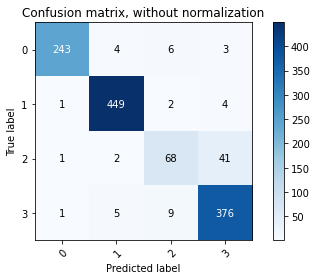

In [14]:
plot_confusion_matrix(y1_test, y1_pred, normalize=False)
print(classification_report(y1_test, y1_pred))

In [15]:
x_data_copy = x_data.copy()

In [16]:
i = 0
x_data_copy['graph'] = '0'
x_data_copy['number_of_nodes'] = 0
x_data_copy['number_of_edges'] = 0
x_data_copy['parts'] = 0
x_data_copy['diameter'] = 0
x_data_copy['simple_cycles'] = 0

In [ ]:
with open("noduplicatedataset.json",'r') as f:
    lines = f.readlines()
    for item in lines:
        #print(item.index)
        d = json.loads(item)
        nx_graph = json_graph.adjacency_graph(d['cfg'])
        x_data_copy['graph'][i] = nx_graph
        x_data_copy['number_of_nodes'][i] = nx.number_of_nodes(nx_graph)
        x_data_copy['number_of_edges'][i] = nx.number_of_edges(nx_graph)
        x_data_copy['parts'][i] = nx.components.number_strongly_connected_components(nx_graph)
        x_data_copy['diameter'][i] = nx.diameter(nx_graph.to_undirected())
        i += 1

In [18]:
x_data_copy['complexity'] = x_data_copy['number_of_edges'] - x_data_copy['number_of_nodes'] + x_data_copy['parts']

In [19]:
x_data_copy_clear = x_data_copy.copy()
x_data_copy_clear = x_data_copy_clear[(x_data_copy_clear['id'] != 8685) & (x_data_copy_clear['id'] != 14999)
                                        & (x_data_copy_clear['id'] != 1087) & (x_data_copy_clear['id'] != 10862)
                                        & (x_data_copy_clear['id'] != 6168) & (x_data_copy_clear['id'] != 12044)
                                        & (x_data_copy_clear['id'] != 10258) & (x_data_copy_clear['id'] != 1086)
                                        & (x_data_copy_clear['id'] != 15000) & (x_data_copy_clear['id'] != 6169)
                                        & (x_data_copy_clear['id'] != 8683) & (x_data_copy_clear['id'] != 1779)
                                        & (x_data_copy_clear['id'] != 10861) & (x_data_copy_clear['id'] != 1778)]

In [20]:
with tf.device('/GPU:0'):
    for row in x_data_copy_clear.index:
      print('row: ', row)
      x_data_copy_clear['simple_cycles'][row] = len(tuple(nx.simple_cycles(x_data_copy_clear['graph'][row])))
      print('cycles: ', x_data_copy_clear['simple_cycles'][row])

row:  0
cycles:  0
row:  1
cycles:  0
row:  2
cycles:  23
row:  3
cycles:  0
row:  4
cycles:  5
row:  5
cycles:  0
row:  6
cycles:  20
row:  7
cycles:  1
row:  8
cycles:  22
row:  9
cycles:  0
row:  10
cycles:  1
row:  11
cycles:  2
row:  12
cycles:  1
row:  13
cycles:  12
row:  14
cycles:  0
row:  15
cycles:  1
row:  16
cycles:  0
row:  17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Выходные данные были обрезаны до нескольких последних строк (5000).
row:  3565
cycles:  0
row:  3566
cycles:  13
row:  3567
cycles:  0
row:  3568
cycles:  0
row:  3569
cycles:  0
row:  3570
cycles:  0
row:  3571
cycles:  0
row:  3572
cycles:  114
row:  3573
cycles:  0
row:  3574
cycles:  0
row:  3575
cycles:  15
row:  3576
cycles:  0
row:  3577
cycles:  0
row:  3578
cycles:  2
row:  3579
cycles:  1
row:  3580
cycles:  3
row:  3581
cycles:  0
row:  3582
cycles:  0
row:  3583
cycles:  0
row:  3584
cycles:  0
row:  3585
cycles:  0
row:  3586
cycles:  2
row:  3587
cycles:  1
row:  3588
cycles:  0
row:  3589
cycles:  0
row:  3590
cycles:  0
row:  3591
cycles:  0
row:  3592
cycles:  1
row:  3593
cycles:  189
row:  3594
cycles:  0
row:  3595
cycles:  0
row:  3596
cycles:  2
row:  3597
cycles:  0
row:  3598
cycles:  0
row:  3599
cycles:  0
row:  3600
cycles:  3
row:  3601
cycles:  0
row:  3602
cycles:  0
row:  3603
cycles:  0
row:  3604
cycles:  3
row:  3605
cycles:  0
row:  3606
cycles:  0
ro

In [60]:
default_enc = x_data_copy_clear[x_data_copy_clear['semantic'] == 'encryption']['simple_cycles'].max()
default_enc

834984

In [22]:
high_weight_enc_ids = [8685,14999,1087,10862,6168,12044,10258,1086,15000,6169,8683,1779,10861,1778]

In [23]:
for id in x_data_copy['id']:
    if id in high_weight_enc_ids:
        x_data_copy.loc[x_data_copy['id'] == id, ['simple_cycles']] = default_enc
    else:
        x_data_copy.loc[x_data_copy['id'] == id, ['simple_cycles']] = x_data_copy_clear.loc[x_data_copy_clear['id'] == id, ['simple_cycles']]

In [24]:
X2 = x_data_copy.drop(columns = ['id', 'semantic', 'lista_asm', 'cfg', 'graph', 'parts'])
t2 = x_data_copy['semantic']

In [25]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, t2, 
          test_size=0.2, random_state=15)

In [27]:
print('Dataset: with CFG features')
print('Number of features: %d' %X2.shape[1])
print('Number of samples: %d' %X2.shape[0])
print('Training set size: %d' %len(X2_train))
print('Test set size: %d' %len(X2_test))

Dataset: with CFG features
Number of features: 15
Number of samples: 6073
Training set size: 4858
Test set size: 1215


In [28]:
classifier2 = svm.SVC(C=1.0, kernel='linear')

In [29]:
classifier2.fit(X2_train,y2_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
y2_pred = classifier2.predict(X2_test)

              precision    recall  f1-score   support

  encryption       0.99      0.96      0.97       256
        math       0.96      0.99      0.98       456
        sort       0.90      0.93      0.92       112
      string       0.99      0.96      0.97       391

    accuracy                           0.97      1215
   macro avg       0.96      0.96      0.96      1215
weighted avg       0.97      0.97      0.97      1215



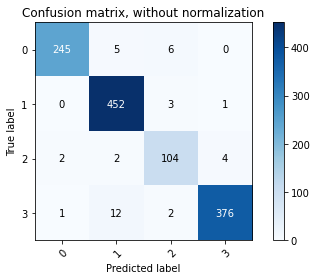

In [31]:
plot_confusion_matrix(y2_test, y2_pred, normalize=False)
print(classification_report(y2_test, y2_pred))

# Blind Test




In [32]:
x_blind_data = pd.read_json('blindtest.json',lines=True)

In [33]:
x_blind_data['data_movements'] = 0
x_blind_data['arithmetic'] = 0
x_blind_data['shifts'] = 0
x_blind_data['comparisons'] = 0
x_blind_data['jumps'] = 0
x_blind_data['calls'] = 0
x_blind_data['bitwise'] = 0
x_blind_data['func_reg'] = 0
x_blind_data['stack_reg'] = 0
x_blind_data['xmm_reg'] = 0

In [ ]:
for row in x_blind_data.index:
  x_blind_data['data_movements'][row] = sum(x_blind_data['lista_asm'][row].count(str) for str in data_movements)
  x_blind_data['arithmetic'][row] = sum(x_blind_data['lista_asm'][row].count(str) for str in arithmetic)
  x_blind_data['shifts'][row] = sum(x_blind_data['lista_asm'][row].count(str) for str in shifts)
  x_blind_data['comparisons'][row] = sum(x_blind_data['lista_asm'][row].count(str) for str in comparisons)
  x_blind_data['jumps'][row] = sum(x_blind_data['lista_asm'][row].count(str) for str in jumps)
  x_blind_data['calls'][row] = sum(x_blind_data['lista_asm'][row].count(str) for str in calls)
  x_blind_data['bitwise'][row] = sum(x_blind_data['lista_asm'][row].count(str) for str in bitwise)
  x_blind_data['func_reg'][row] = sum(x_blind_data['lista_asm'][row].count(str) for str in func_reg)
  x_blind_data['stack_reg'][row] = sum(x_blind_data['lista_asm'][row].count(str) for str in stack_reg)
  x_blind_data['xmm_reg'][row] = sum(x_blind_data['lista_asm'][row].count(str) for str in spec_reg)

In [35]:
i = 0
x_blind_data['graph'] = '0'
x_blind_data['number_of_nodes'] = 0
x_blind_data['number_of_edges'] = 0
x_blind_data['parts'] = 0
x_blind_data['diameter'] = 0
x_blind_data['simple_cycles'] = 0

In [ ]:
with open("blindtest.json",'r') as f:
    lines = f.readlines()
    for item in lines:
        #print(item.index)
        d = json.loads(item)
        nx_graph = json_graph.adjacency_graph(d['cfg'])
        x_blind_data['graph'][i] = nx_graph
        x_blind_data['number_of_nodes'][i] = nx.number_of_nodes(nx_graph)
        x_blind_data['number_of_edges'][i] = nx.number_of_edges(nx_graph)
        x_blind_data['parts'][i] = nx.components.number_strongly_connected_components(nx_graph)
        x_blind_data['diameter'][i] = nx.diameter(nx_graph.to_undirected())
        i += 1

In [37]:
x_blind_data['complexity'] = x_blind_data['number_of_edges'] - x_blind_data['number_of_nodes'] + x_blind_data['parts']

In [38]:
x_blind_data_copy_clear = x_blind_data.copy()
x_blind_data_copy_clear = x_blind_data_copy_clear[x_blind_data_copy_clear['id'] != 10256]

In [39]:
with tf.device('/GPU:0'):
    for row in x_blind_data_copy_clear.index:
      print('row: ', row)
      x_blind_data_copy_clear['simple_cycles'][row] = len(tuple(nx.simple_cycles(x_blind_data_copy_clear['graph'][row])))
      print('cycles: ', x_blind_data_copy_clear['simple_cycles'][row])

row:  0
cycles:  74916
row:  1
cycles:  0
row:  2
cycles:  0
row:  3
cycles:  0
row:  4
cycles:  0
row:  5
cycles:  0
row:  6
cycles:  0
row:  7
cycles:  2
row:  8
cycles:  5
row:  9
cycles:  1
row:  10
cycles:  0
row:  11
cycles:  0
row:  12
cycles:  12
row:  13
cycles:  8
row:  14
cycles:  0
row:  15
cycles:  0
row:  16
cycles:  2
row:  17
cycles:  1
row:  18
cycles:  4
row:  19
cycles:  0
row:  20
cycles:  0
row:  21
cycles:  0
row:  22
cycles:  16
row:  23
cycles:  0
row:  24
cycles:  33
row:  25
cycles:  0
row:  26
cycles:  0
row:  27
cycles:  0
row:  28
cycles:  0
row:  29
cycles:  3
row:  30
cycles:  5
row:  31
cycles:  17
row:  32
cycles:  7
row:  33
cycles:  34
row:  34
cycles:  0
row:  35
cycles:  12
row:  36
cycles:  1
row:  37
cycles:  0
row:  38
cycles:  13
row:  39
cycles:  1
row:  40
cycles:  5
row:  41
cycles:  0
row:  42
cycles:  8
row:  43
cycles:  0
row:  44
cycles:  6
row:  45
cycles:  2
row:  46
cycles:  3
row:  47
cycles:  0
row:  48
cycles:  1
row:  49
cycles:  5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


cycles:  65867
row:  61
cycles:  5
row:  62
cycles:  0
row:  63
cycles:  0
row:  64
cycles:  2
row:  65
cycles:  12
row:  66
cycles:  0
row:  67
cycles:  11
row:  68
cycles:  11
row:  69
cycles:  12
row:  70
cycles:  2
row:  71
cycles:  12
row:  72
cycles:  2
row:  73
cycles:  13
row:  74
cycles:  0
row:  75
cycles:  8
row:  76
cycles:  10
row:  77
cycles:  21
row:  78
cycles:  10
row:  79
cycles:  7
row:  80
cycles:  3
row:  81
cycles:  0
row:  82
cycles:  0
row:  83
cycles:  6
row:  84
cycles:  6
row:  85
cycles:  0
row:  86
cycles:  2
row:  87
cycles:  17
row:  88
cycles:  1
row:  89
cycles:  0
row:  90
cycles:  1
row:  91
cycles:  10
row:  92
cycles:  2
row:  93
cycles:  2
row:  94
cycles:  11
row:  95
cycles:  0
row:  96
cycles:  1
row:  97
cycles:  20
row:  98
cycles:  16
row:  99
cycles:  0
row:  100
cycles:  0
row:  101
cycles:  13
row:  102
cycles:  21
row:  103
cycles:  35
row:  104
cycles:  1
row:  105
cycles:  0
row:  106
cycles:  0
row:  107
cycles:  0
row:  108
cycles:  0

In [61]:
for id in x_blind_data['id']:
    if id == 10256:
        x_blind_data.loc[x_blind_data['id'] == id, ['simple_cycles']] = default_enc
    else:
        x_blind_data.loc[x_blind_data['id'] == id, ['simple_cycles']] = x_blind_data_copy_clear.loc[x_blind_data_copy_clear['id'] == id, ['simple_cycles']]

In [63]:
X_blind_test = x_blind_data.drop(columns = ['id', 'lista_asm', 'cfg', 'graph', 'parts'])

In [64]:
y_blind_test_pred = classifier2.predict(X_blind_test)

In [65]:
y_blind_test_pred

array(['encryption', 'math', 'string', 'string', 'math', 'string', 'math',
       'encryption', 'sort', 'math', 'math', 'math', 'sort', 'encryption',
       'math', 'math', 'string', 'string', 'sort', 'math', 'math',
       'string', 'encryption', 'math', 'encryption', 'string', 'string',
       'math', 'math', 'string', 'sort', 'sort', 'sort', 'sort', 'string',
       'sort', 'string', 'math', 'sort', 'math', 'sort', 'math', 'sort',
       'math', 'sort', 'sort', 'sort', 'string', 'string', 'string',
       'sort', 'math', 'math', 'string', 'math', 'string', 'math', 'math',
       'math', 'math', 'encryption', 'sort', 'math', 'string', 'string',
       'sort', 'math', 'string', 'sort', 'sort', 'math', 'sort', 'string',
       'sort', 'math', 'sort', 'sort', 'sort', 'sort', 'sort', 'string',
       'encryption', 'math', 'sort', 'string', 'math', 'math', 'math',
       'encryption', 'math', 'string', 'string', 'string', 'sort', 'sort',
       'string', 'math', 'encryption', 'encryption'

In [71]:
pd.DataFrame(y_blind_test_pred).to_csv(r'1937430.txt', header=None, index=None, sep=' ', mode='a')